# XGBoost and LightGBM Comparison

## Imports

In [1]:

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Suppress macOS compiled SSL warnings 
    # (https://github.com/urllib3/urllib3/issues/3020)
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import pandas as pd
    import yfinance as yf
    import xgboost as xgb
    import lightgbm as lgb

%matplotlib inline

## Load FTSE100 Historical Data
- Daily data over the last 2 years

In [2]:
# FTSE 100 reference
ftse100_ticker = yf.Ticker("^FTSE")
# History of daily prices over the last 2 years
ftse100_2y1d = ftse100_ticker.history(
    period="2y", 
    interval="1d"
)
# This is initially in chronological order (earliest to latest), calculate 
# the technical features from this
def compute_sma(df, feature_name, timeframe):
    """ Simple moving average """

    return df[feature_name].rolling(window=timeframe).mean()
def compute_ema(df, feature_name, timeframe):
    """ Exponential moving average """

    return df[feature_name].ewm(span=timeframe, min_periods=timeframe, adjust=False).mean()

for t in [5, 15, 30]:
    ftse100_2y1d[f"SMA{t}"] = compute_sma(ftse100_2y1d, "Close", t)
for t in [9, 12, 26]:
    ftse100_2y1d[f"EMA{t}"] = compute_ema(ftse100_2y1d, "Close", t)
# moving average convergence/divergence
ftse100_2y1d["MACD"] = ftse100_2y1d["EMA12"] - ftse100_2y1d["EMA26"]
# open to close difference, 7 day SMA
ftse100_2y1d["Diff"] = ftse100_2y1d["Close"] - ftse100_2y1d["Open"]
ftse100_2y1d["DiffAvg"] = compute_sma(ftse100_2y1d, "Diff", 7)
# high-low difference, 7 day SMA
ftse100_2y1d["Range"] = ftse100_2y1d["High"] - ftse100_2y1d["Low"]
ftse100_2y1d["RangeAvg"] = compute_sma(ftse100_2y1d, "Range", 7)

""" Sort in reverse chronological order, most recent first """
ftse100_2y1d.sort_values("Date", ascending=False, inplace=True)

# Visualise the data to see the full extent of what is available
ftse100_2y1d

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA5,SMA15,SMA30,EMA9,EMA12,EMA26,MACD,Diff,DiffAvg,Range,RangeAvg
Date,,,,,,,,,,,,,,,,,,
2023-12-12 00:00:00+00:00,7544.890137,7577.609863,7544.890137,7576.660156,0,0.0,0.0,7541.032031,7498.124023,7465.705339,7526.069222,7515.853816,7490.947653,24.906163,31.770020,6.752860,32.719727,53.802804
2023-12-11 00:00:00+00:00,7554.500000,7557.399902,7493.600098,7544.899902,872408400,0.0,0.0,7523.659961,7491.813346,7457.206673,7513.421488,7504.798118,7484.090653,20.707465,-9.600098,13.014300,63.799805,61.257185
2023-12-08 00:00:00+00:00,7513.700195,7581.299805,7509.799805,7554.500000,863626100,0.0,0.0,7517.279980,7488.580013,7449.956673,7505.551884,7497.506884,7479.225913,18.280971,40.799805,18.714286,71.500000,67.942941
2023-12-07 00:00:00+00:00,7515.399902,7523.600098,7480.500000,7513.700195,811058900,0.0,0.0,7512.259961,7485.233333,7441.183333,7493.314855,7487.144500,7473.203986,13.940514,-1.699707,8.357143,43.100098,64.685826
2023-12-06 00:00:00+00:00,7489.799805,7542.600098,7486.799805,7515.399902,1489645900,0.0,0.0,7500.279883,7478.386654,7435.879997,7488.218521,7482.316191,7469.964289,12.351902,25.600098,7.814244,55.800293,66.785854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 00:00:00+00:00,7260.600098,7286.500000,7236.200195,7269.899902,1477578800,0.0,0.0,7230.259961,NaN,NaN,NaN,NaN,NaN,NaN,9.299805,NaN,50.299805,NaN
2021-12-16 00:00:00+00:00,7170.799805,7273.299805,7170.799805,7260.600098,1155236100,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.800293,NaN,102.500000,NaN
2021-12-15 00:00:00+00:00,7218.600098,7224.899902,7166.799805,7170.799805,813609300,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-47.800293,NaN,58.100098,NaN


## Engineer features for forecasting
- Lag features
- Moving Averages/Statistics
- Time features
- Technical features

See: 

Nabi, R.M., Saeed, S.A. and Abdi, A.M., 2020. Feature Engineering for Stock Price Prediction. Int. J. Adv. Sci. Technol, 29(12s), pp.2486-2496.

Dey, S., Kumar, Y., Saha, S. and Basak, S., 2016. Forecasting to Classification: Predicting the direction of stock market price using Xtreme Gradient Boosting. PESIT South Campus, pp.1-10.

In [3]:
def lag_df_feature(df, feature_name, feature_lag):
    """ Look back at the previous values of a feature up to the given lag. 
    This creates new instance points.
    
    Args:
        df(Pandas.DataFrame): Target dataframe
        feature_name(str): Name of the feature of interest
        feature_lag(int): Given feature lag to look back up to
    """
    for i in range(1, feature_lag + 1):
        df[f"{feature_name}-{i}"] = df[feature_name].shift(-i)

def lag_feature_name(feature_name, feature_lag):
    """ Names of the lag features based on the name of an 
    original feature.
    
    Args:
        feature_name(str): Original feature that was lagged
        feature_lag(int): Lag of that feature

    Returns:
        List[str]: List of lag feature names
    """

    return [f"{feature_name}-{i}" for i in range(1, feature_lag + 1)]


# Preprocess
X = ftse100_2y1d.copy()
target_name = "Close"

# Filter and create the following features, including lag and technical ones
feature_lag = 7
eng_features = [
    "DayOfYear", 
    *lag_feature_name("Close", feature_lag), "CloseStd", 
    "SMA15", 
    "EMA9", "MACD", 
    "DiffAvg", "RangeAvg"
]

X["DayOfYear"] = X.index.dayofyear
lag_df_feature(X, "Close", feature_lag)
# All na have now been encountered (from technicals and lag), so they can 
# be filtered out at this stage
X.dropna(inplace=True)
X["CloseStd"] = X[[*lag_feature_name("Close", feature_lag)]].std(axis=1)

# Finalise the chosen features and populate the targets
X, y = X[eng_features], X[target_name]

# Visualise the dataset
display(X)
display(y)

,DayOfYear,Close-1,Close-2,Close-3,Close-4,Close-5,Close-6,Close-7,CloseStd,SMA15,EMA9,MACD,DiffAvg,RangeAvg
Date,,,,,,,,,,,,,,
2023-12-12 00:00:00+00:00,346,7544.899902,7554.500000,7513.700195,7515.399902,7489.799805,7513.000000,7529.399902,21.830034,7498.124023,7526.069222,24.906163,6.752860,53.802804
2023-12-11 00:00:00+00:00,345,7554.500000,7513.700195,7515.399902,7489.799805,7513.000000,7529.399902,7453.799805,31.556678,7491.813346,7513.421488,20.707465,13.014300,61.257185
2023-12-08 00:00:00+00:00,342,7513.700195,7515.399902,7489.799805,7513.000000,7529.399902,7453.799805,7423.500000,38.752174,7488.580013,7505.551884,18.280971,18.714286,67.942941
2023-12-07 00:00:00+00:00,341,7515.399902,7489.799805,7513.000000,7529.399902,7453.799805,7423.500000,7455.200195,39.400839,7485.233333,7493.314855,13.940514,8.357143,64.685826
2023-12-06 00:00:00+00:00,340,7489.799805,7513.000000,7529.399902,7453.799805,7423.500000,7455.200195,7460.700195,37.239262,7478.386654,7488.218521,12.351902,7.814244,66.785854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01 00:00:00+00:00,32,7464.399902,7466.100098,7554.299805,7469.799805,7371.500000,7297.200195,7494.100098,84.695609,7510.753353,7489.254181,31.090796,5.957101,135.942871
2022-01-31 00:00:00+00:00,31,7466.100098,7554.299805,7469.799805,7371.500000,7297.200195,7494.100098,7585.000000,100.086011,7507.793359,7477.617776,28.637642,-17.228585,142.828613
2022-01-28 00:00:00+00:00,28,7554.299805,7469.799805,7371.500000,7297.200195,7494.100098,7585.000000,7589.700195,111.108133,7506.520020,7480.922244,32.359786,-17.657157,142.257185


Date
2023-12-12 00:00:00+00:00    7576.660156
2023-12-11 00:00:00+00:00    7544.899902
2023-12-08 00:00:00+00:00    7554.500000
2023-12-07 00:00:00+00:00    7513.700195
2023-12-06 00:00:00+00:00    7515.399902
                                ...     
2022-02-01 00:00:00+00:00    7535.799805
2022-01-31 00:00:00+00:00    7464.399902
2022-01-28 00:00:00+00:00    7466.100098
2022-01-27 00:00:00+00:00    7554.299805
2022-01-26 00:00:00+00:00    7469.799805
Name: Close, Length: 474, dtype: float64

## Split the training and testing data

In [4]:
from sklearn.model_selection import train_test_split

def rchron_train_test_split(X, y, test_frac):
    X_test, X_train, y_test, y_train = train_test_split(
        X, y, 
        train_size=test_frac, shuffle=False
    )
    # train, test
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = rchron_train_test_split(X, y, test_frac=0.2)

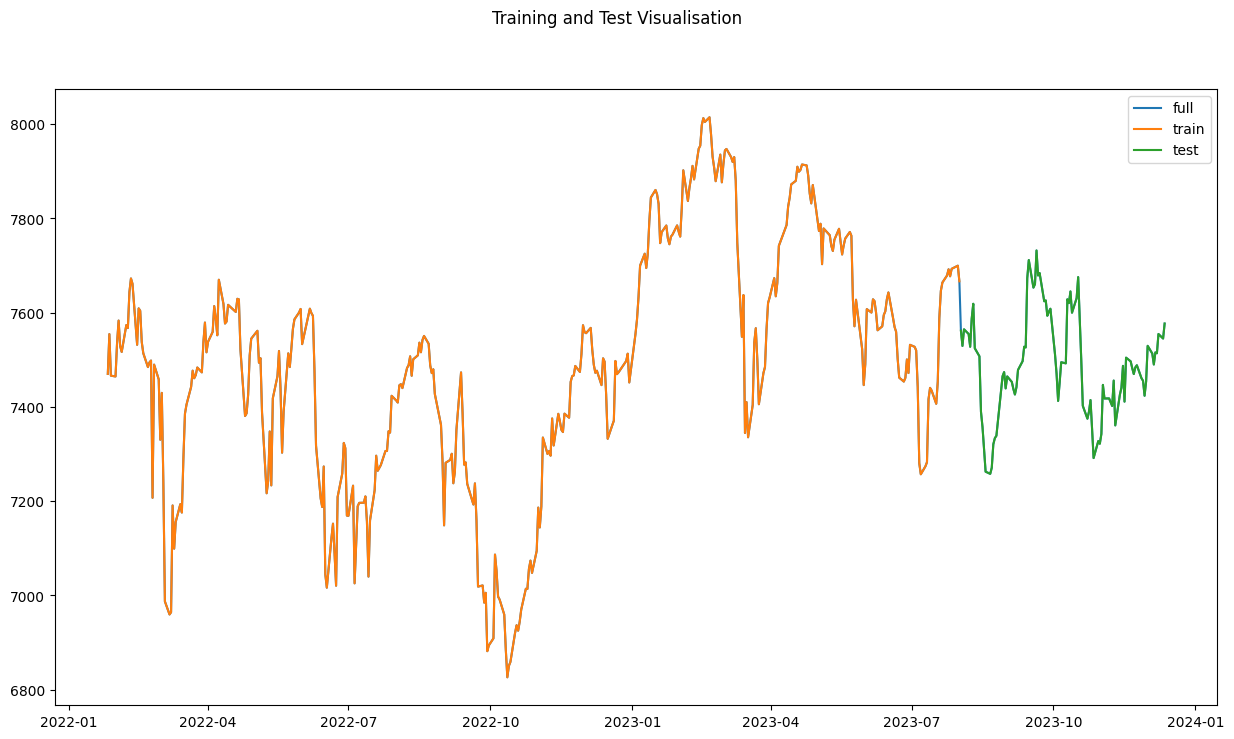

In [5]:
# Visualise the training and testing data

plt.figure(figsize=(15, 8))
plt.plot(y.index, y, label="full")
plt.plot(y_train.index, y_train, label="train")
plt.plot(y_test.index, y_test, label="test")
plt.suptitle("Training and Test Visualisation")
plt.legend()

## Train XGBoost
* Make test predictions

In [6]:
import sklearn

# Train XGBoost
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [7]:
# Make predictions
pred_test = reg.predict(X_test)

def time_tag_preds(raw_preds, index):
    """ Time tag the raw predictions """
    return pd.Series(raw_preds, index=index)

# Re-add time
pred_test = time_tag_preds(pred_test, y_test.index)

# Display the predictions
display(pred_test)

Date
2023-12-12 00:00:00+00:00    7594.724121
2023-12-11 00:00:00+00:00    7563.924316
2023-12-08 00:00:00+00:00    7530.544922
2023-12-07 00:00:00+00:00    7503.113281
2023-12-06 00:00:00+00:00    7518.138184
                                ...     
2023-08-08 00:00:00+01:00    7509.157227
2023-08-07 00:00:00+01:00    7541.173828
2023-08-04 00:00:00+01:00    7540.849609
2023-08-03 00:00:00+01:00    7547.973633
2023-08-02 00:00:00+01:00    7600.035156
Length: 94, dtype: float32

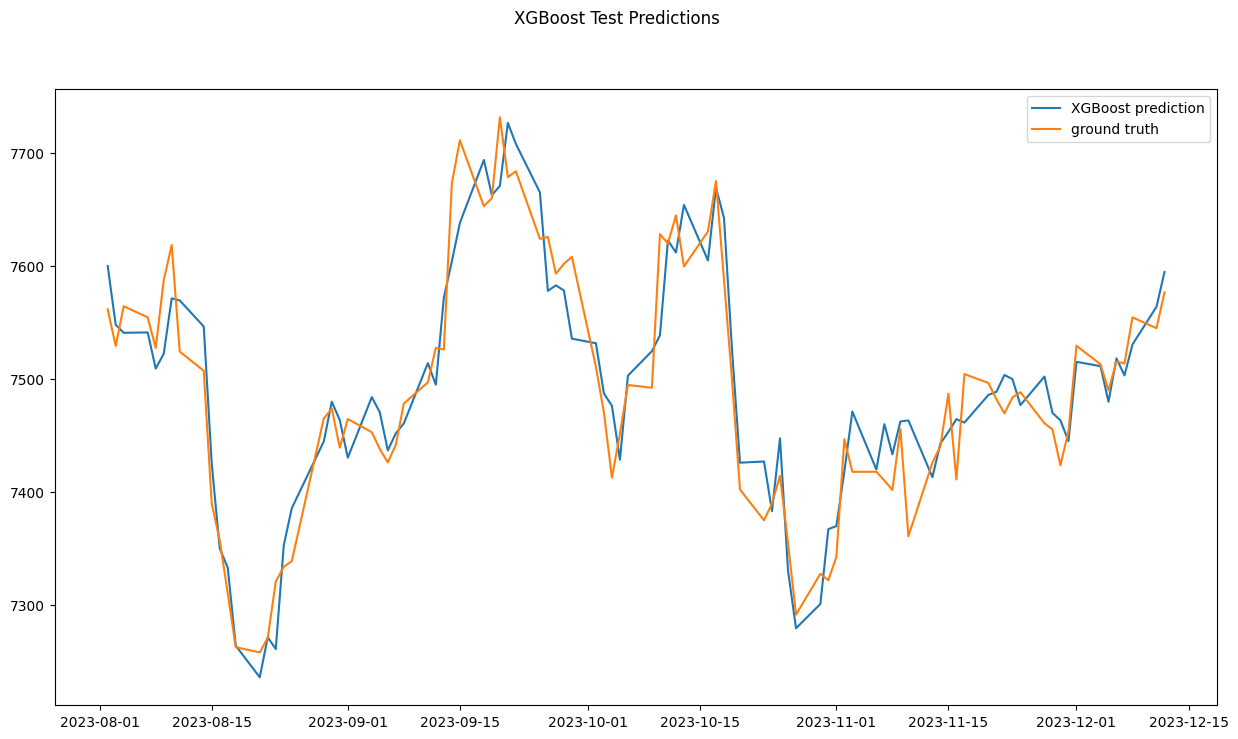

In [8]:
# Visualise the predictions

plt.figure(figsize=(15, 8))
plt.plot(pred_test.index, pred_test, label="XGBoost prediction")
plt.plot(y_test.index, y_test, label="ground truth")
plt.suptitle("XGBoost Test Predictions")
plt.legend()

## Train LightGBM
* Make test predictions

In [9]:
# Train lightGBM
lreg = lgb.LGBMRegressor(n_estimators=1000)
lreg.fit(X_train, y_train)
# Predict, re-add time
lgb_pred_test = lreg.predict(X_test)
lgb_pred_test = time_tag_preds(lgb_pred_test, y_test.index)

# show predictions
display(lgb_pred_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1778
[LightGBM] [Info] Number of data points in the train set: 380, number of used features: 14
[LightGBM] [Info] Start training from score 7480.650008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

Date
2023-12-12 00:00:00+00:00    7558.733084
2023-12-11 00:00:00+00:00    7548.562506
2023-12-08 00:00:00+00:00    7517.685677
2023-12-07 00:00:00+00:00    7493.283682
2023-12-06 00:00:00+00:00    7512.170802
                                ...     
2023-08-08 00:00:00+01:00    7544.509243
2023-08-07 00:00:00+01:00    7552.358137
2023-08-04 00:00:00+01:00    7559.684360
2023-08-03 00:00:00+01:00    7520.433608
2023-08-02 00:00:00+01:00    7523.409511
Length: 94, dtype: float64

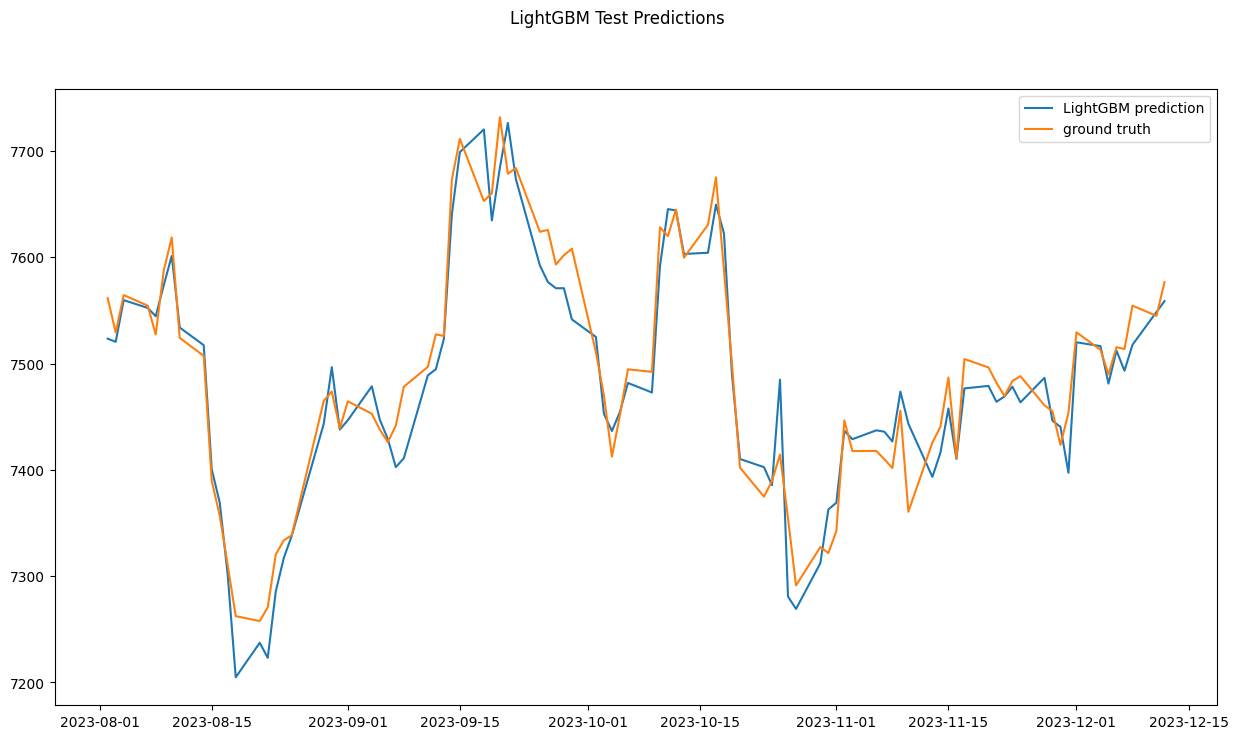

In [10]:
# Visualise the predictions

plt.figure(figsize=(15, 8))
plt.plot(lgb_pred_test.index, lgb_pred_test, label="LightGBM prediction")
plt.plot(y_test.index, y_test, label="ground truth")
plt.suptitle("LightGBM Test Predictions")
plt.legend()

## Evaluation Metrics

In [11]:
from sklearn.metrics import mean_absolute_percentage_error

#Calculate MAPE for each method
print("-- Mean Absolute Percentage Error --")
print(f"XGBoost: {mean_absolute_percentage_error(y_test, pred_test):.3%}")
print(f"LightGBM: {mean_absolute_percentage_error(y_test, lgb_pred_test):.3%}")

-- Mean Absolute Percentage Error --
XGBoost: 0.388%
LightGBM: 0.306%
